<a href="https://colab.research.google.com/github/john-reilly/RoboFarm/blob/master/Apples_version2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
base_dir = '/content/gdrive/My Drive/'

In [0]:
#REQUIREMENTS 
!Flask==0.11.1
!attrdict==2.0.0
!eventlet==0.19.0
!numpy==1.13.1
!scipy==0.19.1
!keras==2.0.8
!tensorflow==1.3.0
!h5py==2.6.0
!pandas==0.24.2
!Pillow==2.8.0

In [0]:
import os
import random
import time

import tensorflow as tf
import numpy as np
from PIL import Image, ImageOps


class ObjectDetector:

    def __init__(self,location_path = base_dir, graph_filename = 'frozen_inference_graph.pb' ):       
        self.detection_graph = tf.Graph()
        with self.detection_graph.as_default():
            od_graph_def = tf.GraphDef()
            try:
                with tf.gfile.GFile( location_path + graph_filename, 'rb') as fid:
                    serialized_graph = fid.read()
                    od_graph_def.ParseFromString(serialized_graph)
                    tf.import_graph_def(od_graph_def, name='')
                    self.session = tf.Session(graph=self.detection_graph)
            except Exception as e:
                print(e)
                exit()


    def run_inference_for_single_image(self, image, show_stats = True ):
        # Get handles to input and output tensors
        ops = self.detection_graph.get_operations()
        all_tensor_names = {output.name for op in ops for output in op.outputs}
        tensor_dict = {}
        for key in ['num_detections', 'detection_boxes', 'detection_scores', 'detection_classes']:
            tensor_name = key + ':0'
            if tensor_name in all_tensor_names:
                tensor_dict[key] = self.detection_graph.get_tensor_by_name(tensor_name)
        image_tensor = self.detection_graph.get_tensor_by_name('image_tensor:0') #indentation?

        # Run inference
        start = time.time()
        output_dict = self.session.run(tensor_dict, feed_dict={image_tensor: np.expand_dims(image, 0)})
        elapsed = time.time() - start
        #print('inference took:', elapsed, ' seconds') 
        
        # all outputs are float32 numpy arrays, so convert types as appropriate
        output_dict['num_detections'] = int(output_dict['num_detections'][0])
        output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.uint8)
        output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
        output_dict['detection_scores'] = output_dict['detection_scores'][0]

        if show_stats == True:
          print('inference took:', elapsed, ' seconds') 
          print("num_detections:" , output_dict['num_detections'])
          print("Detection Classes: " , output_dict['detection_classes'])
          print("Detection Scores: " , output_dict['detection_scores'])

        return output_dict

    def overlay_bounding_boxes(self, image, output_dict,detection_class, probability_level, draw_boxes = False):
        classes = output_dict['detection_classes']
        boxes = output_dict['detection_boxes']
        scores = output_dict['detection_scores']

        height, width, _ = image.shape

        tf_boxes = []
        output_images = []
        for i in range(len(boxes)):
            confidence = float(scores[i])
            ymin, xmin, ymax, xmax = tuple(boxes[i].tolist())
            ymin = int(ymin * height)
            ymax = int(ymax * height)
            xmin = int(xmin * width)
            xmax = int(xmax * width)
            box_width = xmax - xmin
            box_height = ymax - ymin
            box_ratio = float(box_height) / box_width 
            #filter criteria
            if confidence >= probability_level and \
              classes[i] == detection_class :
                # also possible and \  #box_ratio >= 0.75     #box_width > 21   #box_height > 20
                #draw rectanlge around object having this here interferes with later on as cropped images have rectanlge over writes
                if draw_boxes:
                  cv2.rectangle(image, (xmin,ymin) , (xmax, ymax) , (255,0,0) ,2)
                #record object data
                tf_boxes.append(boxes[i])
                #crop object out of image for further processing
                crop_image = image[ymin:ymax, xmin:xmax]
                crop_output_image = Image.fromarray(crop_image)
                output_images.append(crop_output_image)
                
        return image, tf_boxes , output_images



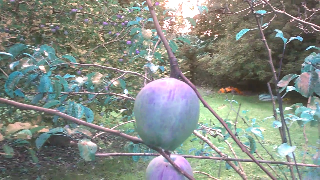

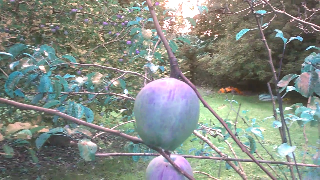

In [6]:

from google.colab.patches import cv2_imshow
from moviepy.editor import VideoFileClip
from IPython.display import HTML #from my lane line project
import cv2

clip1 = VideoFileClip(base_dir + 'APPLE_VIDEO.MP4')
frame = clip1.get_frame(3)#3) #19

#Before processing
#frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
cv2_imshow( cv2.resize(frame, None, fx = 0.25 , fy = 0.25, interpolation = cv2.INTER_CUBIC) )


my_detector = ObjectDetector(base_dir , 'frozen_inference_graph.pb')
output_dict = my_detector.run_inference_for_single_image(frame, show_stats = False) # True)
#frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)#is rgb getting screwed up?
final_image, object_data, object_images  = my_detector.overlay_bounding_boxes( frame, output_dict,53, 0.04, draw_boxes = False ) #True)
#After processing
#cv2_imshow(final_image)
cv2_imshow( cv2.resize(final_image, None, fx = 0.25 , fy = 0.25, interpolation = cv2.INTER_CUBIC) )


In [8]:
#TRAIN.py
# Load the data

import gzip
import re
import os

import numpy as np
import pandas as pd
from time import time
from PIL import Image, ImageOps

from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import keras.layers as layers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.callbacks import TensorBoard
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.backend import tensorflow_backend as ktf
from pathlib import Path

from os import listdir
from os.path import isfile, join


apple_type = ['ripe', 'not_ripe']
apple_type_categories = [[1,0], [0,1]]

RESIZED_DIR = base_dir + 'data/' + 'Ripe_not_ripe/' + 'images_resized/'

def read_images(images_path):
    labels = []
    features = []
    for root, dirs, files in os.walk(images_path, topdown=False):
        
        path = os.path.dirname(images_path + 'images_resized/')
        Path(path).mkdir(exist_ok=True)
        
        for filename in files:
            added = False
        
            for index, color in enumerate(apple_type):              
                labels.append(apple_type_categories[index])
                print(images_path + apple_type[index]+ '/' + filename)
                img = load_img(images_path + apple_type[index]+ '/' + filename)
                img = crop_image(img)
                img.save('{}{}{}'.format(RESIZED_DIR,  apple_type[index]+ '/' ,filename), 'JPEG')
                x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150) 
                features.append(x)
                added = True
                break
            if not added:
                print('Error invalid filename:', filename)

    return np.array(features), np.array(labels)

def preprocess_images(images_path):
  
    if not os.path.exists(images_path + 'preprocessed/' + 'ripe/' ):
      os.makedirs(images_path + 'preprocessed/' + 'ripe/' )
  
    for root, dirs, files in os.walk(images_path+'ripe/', topdown=True):    
      for filename in files:
        img = load_img(images_path + 'ripe/' + filename)
        img = crop_image(img)
        img.save(images_path + 'preprocessed/' + 'ripe/' + filename)


    if not os.path.exists(images_path + 'preprocessed/' + 'not_ripe/' ):
      os.mkdir(images_path + 'preprocessed/' + 'not_ripe/' )

    for root, dirs, files in os.walk(images_path+'not_ripe/', topdown=True):    
      for filename in files:
        img = load_img(images_path + 'not_ripe/' + filename)
        img = crop_image(img)
        img.save(images_path + 'preprocessed/' + 'not_ripe/' + filename)


def load_prepared_images(images_path):
  
  features = []
  labels = []

  for root, dirs, files in os.walk(images_path+'ripe/', topdown=True):    
    for filename in files:
      img = load_img(images_path + 'ripe/' + filename)
      x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150) #john 32*32 ?
      features.append(x)
      labels.append(apple_type_categories[0])


  for root, dirs, files in os.walk(images_path+'not_ripe/', topdown=True):    
    for filename in files:
      img = load_img(images_path + 'not_ripe/' + filename)
      x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150) #john 32*32 ?
      features.append(x)
      labels.append(apple_type_categories[1])
     

  return np.array(features), np.array(labels)


def remove_ext(filename):
    return re.sub(r'\.png|\.jpeg|\.jpg', '', filename, re.IGNORECASE)

def crop_image(img):
    img.thumbnail((32, 32), Image.ANTIALIAS)
    width, height = img.size
    delta_w = 32 - width
    delta_h = 32 - height
    padding = (delta_w // 2, delta_h // 2, delta_w - (delta_w // 2), delta_h - (delta_h // 2))
    img = ImageOps.expand(img, padding, fill=0)  # fill with black dots
    return img



features, labels = load_prepared_images(base_dir + 'data/' + 'Ripe_not_ripe/' + 'preprocessed/')

train = {}
test = {}

train['features'], test['features'], train['labels'], test['labels'] = train_test_split(features, labels, test_size=0.05)

# explore the data

print('# of training images:', train['features'].shape[0])
print('# of test images:', test['features'].shape[0])

# plot training data
train_labels_count = np.unique(train['labels'], return_counts=True)
dataframe_train_labels = pd.DataFrame({'Label':train_labels_count[0], 'Count':train_labels_count[1]})
print(dataframe_train_labels)

# Split training data into training and validation
validation = {}
train['features'], validation['features'], train['labels'], validation['labels'] = train_test_split(train['features'], train['labels'], test_size=0.2, random_state=0)

print('# of training images:', train['features'].shape[0])
print('# of validation images:', validation['features'].shape[0])

print(features.shape)
print(labels.shape)

print("Updated Image Shape: {}".format(train['features'][0].shape))

model = Sequential()

model.add(layers.Lambda(lambda x: x/255.0 - 0.5, input_shape=(32,32,3))) # added

model.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(32,32,3)))
model.add(layers.AveragePooling2D())

model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(layers.AveragePooling2D())

model.add(layers.Flatten())

model.add(layers.Dense(units=120, activation='relu'))

model.add(layers.Dense(units=84, activation='relu'))

model.add(layers.Dense(units=2, activation = 'softmax')) #for 2 categories

model.summary()

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
model.fit(train['features'], train['labels'], epochs=52, validation_split=0.3, shuffle=True, callbacks=[tensorboard])


score = model.evaluate(test['features'], test['labels'])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

model.save(base_dir + 'apple_lenet_model.h5')

# of training images: 243
# of test images: 13
   Label  Count
0      0    243
1      1    243
# of training images: 194
# of validation images: 49
(256, 32, 32, 3)
(256, 2)
Updated Image Shape: (32, 32, 3)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 30, 6)         168       
_________________________________________________________________
average_pooling2d_3 (Average (None, 15, 15, 6)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 16)        880       
_________________________________________________________________
average_pooling2d_4 (Average (None, 6, 6, 16)          0         
_____________________________________________

In [0]:
#classify.py

import numpy as np
from keras.models import load_model
from keras.preprocessing.image import img_to_array, load_img
import time
import os

#class_model = load_model(base_dir + 'apple_lenet_model.h5')

#traffic_light_colors = ['ripe', 'not_ripe']

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


class ObjectClassifier:

    def __init__(self,location_path = base_dir, model_name = 'apple_lenet_model.h5' ):       
  
            try:
              self.class_model = load_model(base_dir + 'apple_lenet_model.h5')
              
            except Exception as e:
                print(e)
                exit()

            self.traffic_light_colors = ['ripe', 'not_ripe']

    def predict(self,image_name):

        img = load_img(image_name, False, target_size=(32, 32))
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        preds = self.class_model.predict_classes(x)
        prob = selfclass_model.predict_proba(x)

        return preds[0], prob[0]

    def predict_for_detected(self, image_name):
      
        resized_image = image_name.resize((32,32), resample=0)

        x = img_to_array(resized_image)
        x = np.expand_dims(x, axis=0)
        preds = self.class_model.predict_classes(x)
        prob = self.class_model.predict_proba(x)

        return preds[0], prob[0]

    def draw_positive_boxes(self,final_image,object_data, object_images, show_each_addition =  False ):

      height, width ,_ = final_image.shape #  as per PIL
      print('final_image.shape : ', final_image.shape)


      for   i in  range(0, len(object_images ) ) :
        start = time.time()
        pred, prob = self.predict_for_detected( object_images[i]) #originally self was not here then it gave trouble for no reason

        #plt.imshow(object_images[i])
        #plt.show()
        elapsed = time.time() - start
        print('Result: ', ':', self.traffic_light_colors[pred], '- prodb:', prob, '-elapsed time:', elapsed, ' s')

        if pred == 0 :
          ymin, xmin, ymax, xmax = tuple(object_data[i].tolist())#tuple(boxes[i].tolist())
          #print('ymin, xmin, ymax, xmax', ymin, xmin, ymax, xmax)
          ymin = int(ymin * height)
          ymax = int(ymax * height)
          xmin = int(xmin * width)
          xmax = int(xmax * width)
          #print('ymin, xmin, ymax, xmax', ymin, xmin, ymax, xmax)

          cv2.rectangle(final_image, (int(xmin),int(ymin)) , (int(xmax),int( ymax) ) , (255,0,0) ,2)
          if show_each_addition  :
            cv2_imshow(final_image)
            

          #return final_image # <-------------wrong indentation caused return only if apple sucessfully calssified

      return final_image

#show_each_addition = False
#last_image = draw_positive_boxes( final_image, object_data, object_images,  show_each_addition )

#total = 0 #not used?
#errors = 0



In [26]:
#the complete pipeline


from google.colab.patches import cv2_imshow
from moviepy.editor import VideoFileClip
from IPython.display import HTML #from my lane line project
import cv2

#clip1 = VideoFileClip(base_dir + 'APPLE_VIDEO.MP4')
#frame = clip1.get_frame(3)#3) #19

#Before processing
#frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#cv2_imshow( cv2.resize(frame, None, fx = 0.25 , fy = 0.25, interpolation = cv2.INTER_CUBIC) )


my_detector = ObjectDetector(base_dir , 'frozen_inference_graph.pb')
my_classifier = ObjectClassifier(base_dir ,'apple_lenet_model.h5'  )


#pipeline

#clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
#yellow_clip = clip2.fl_image(process_image)
#%time yellow_clip.write_videofile(yellow_output, audio=False)

def pipeline(frame) :
  output_dict = my_detector.run_inference_for_single_image(frame, show_stats = False) # True)
  #frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)#is rgb getting screwed up?
  final_image, object_data, object_images  = my_detector.overlay_bounding_boxes( frame, output_dict,53, 0.04, draw_boxes = False ) #True)
  #After processing
  #cv2_imshow(final_image)
  #cv2_imshow( cv2.resize(final_image, None, fx = 0.25 , fy = 0.25, interpolation = cv2.INTER_CUBIC) )

  last_image = my_classifier.draw_positive_boxes(final_image, object_data,object_images)
  

  #cv2_imshow( cv2.resize(last_image, None, fx = 0.25 , fy = 0.25, interpolation = cv2.INTER_CUBIC) ) #fails here if no image or objects?
  
  return last_image #forgot this!!

clip1 = VideoFileClip(base_dir + 'APPLE_VIDEO.MP4').subclip(0,1)
output_clip = clip1.fl_image(pipeline)
output_clip.write_videofile(base_dir + 'output_clip_1.mp4', audio = False)



#white_output = 'test_videos_output\solidWhiteRight_After_Feedback.mp4'


final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [3.0213025e-07 9.9999964e-01] -elapsed time: 0.41957855224609375  s
Result:  : not_ripe - prodb: [4.2892145e-05 9.9995708e-01] -elapsed time: 0.0039675235748291016  s
Result:  : not_ripe - prodb: [3.6877525e-05 9.9996316e-01] -elapsed time: 0.0028443336486816406  s
Result:  : not_ripe - prodb: [7.690303e-09 1.000000e+00] -elapsed time: 0.0027496814727783203  s
Result:  : not_ripe - prodb: [2.6433563e-08 1.0000000e+00] -elapsed time: 0.002582550048828125  s
Result:  : not_ripe - prodb: [4.206654e-09 1.000000e+00] -elapsed time: 0.002807140350341797  s
Result:  : not_ripe - prodb: [8.907139e-08 9.999999e-01] -elapsed time: 0.0028917789459228516  s
Result:  : not_ripe - prodb: [2.4677740e-07 9.9999976e-01] -elapsed time: 0.0027191638946533203  s
Result:  : not_ripe - prodb: [1.9918743e-06 9.9999797e-01] -elapsed time: 0.002954244613647461  s
Result:  : not_ripe - prodb: [1.3906607e-06 9.9999857e-01] -elapsed time: 0.00279617


  3%|▎         | 1/31 [00:00<00:11,  2.72it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [3.0213025e-07 9.9999964e-01] -elapsed time: 0.004396200180053711  s
Result:  : not_ripe - prodb: [4.2892145e-05 9.9995708e-01] -elapsed time: 0.002901792526245117  s
Result:  : not_ripe - prodb: [3.6877525e-05 9.9996316e-01] -elapsed time: 0.0027654170989990234  s
Result:  : not_ripe - prodb: [7.690303e-09 1.000000e+00] -elapsed time: 0.0028235912322998047  s
Result:  : not_ripe - prodb: [2.6433563e-08 1.0000000e+00] -elapsed time: 0.0026814937591552734  s
Result:  : not_ripe - prodb: [4.206654e-09 1.000000e+00] -elapsed time: 0.002628326416015625  s
Result:  : not_ripe - prodb: [8.907139e-08 9.999999e-01] -elapsed time: 0.002597808837890625  s
Result:  : not_ripe - prodb: [2.4677740e-07 9.9999976e-01] -elapsed time: 0.002535581588745117  s
Result:  : not_ripe - prodb: [1.9918743e-06 9.9999797e-01] -elapsed time: 0.0027463436126708984  s
Result:  : not_ripe - prodb: [1.3906607e-06 9.9999857e-01] -elapsed time: 0.00273346


  6%|▋         | 2/31 [00:00<00:10,  2.75it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [2.6268467e-07 9.9999976e-01] -elapsed time: 0.0034117698669433594  s
Result:  : not_ripe - prodb: [3.0036454e-05 9.9996996e-01] -elapsed time: 0.0030612945556640625  s
Result:  : not_ripe - prodb: [9.192633e-08 9.999999e-01] -elapsed time: 0.0028395652770996094  s
Result:  : not_ripe - prodb: [2.3323180e-05 9.9997663e-01] -elapsed time: 0.002774477005004883  s
Result:  : not_ripe - prodb: [1.5652349e-08 1.0000000e+00] -elapsed time: 0.0026459693908691406  s
Result:  : not_ripe - prodb: [8.1030535e-08 9.9999988e-01] -elapsed time: 0.0026068687438964844  s
Result:  : not_ripe - prodb: [4.3809102e-08 1.0000000e+00] -elapsed time: 0.0027031898498535156  s
Result:  : not_ripe - prodb: [6.978090e-07 9.999993e-01] -elapsed time: 0.0025544166564941406  s
Result:  : not_ripe - prodb: [7.4431156e-08 9.9999988e-01] -elapsed time: 0.002584695816040039  s
Result:  : not_ripe - prodb: [2.9333382e-08 1.0000000e+00] -elapsed time: 0.002


 10%|▉         | 3/31 [00:01<00:10,  2.66it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [1.3583633e-06 9.9999869e-01] -elapsed time: 0.003665447235107422  s
Result:  : not_ripe - prodb: [9.059430e-05 9.999094e-01] -elapsed time: 0.0030355453491210938  s
Result:  : not_ripe - prodb: [3.378221e-09 1.000000e+00] -elapsed time: 0.0029938220977783203  s
Result:  : not_ripe - prodb: [6.1698536e-08 9.9999988e-01] -elapsed time: 0.003209829330444336  s
Result:  : not_ripe - prodb: [2.0151946e-08 1.0000000e+00] -elapsed time: 0.002942800521850586  s
Result:  : not_ripe - prodb: [7.986408e-06 9.999920e-01] -elapsed time: 0.0026404857635498047  s
Result:  : not_ripe - prodb: [6.1640404e-09 1.0000000e+00] -elapsed time: 0.0029473304748535156  s
Result:  : not_ripe - prodb: [1.3506138e-07 9.9999988e-01] -elapsed time: 0.0031614303588867188  s
Result:  : not_ripe - prodb: [4.7110257e-06 9.9999523e-01] -elapsed time: 0.002912759780883789  s
Result:  : not_ripe - prodb: [3.3342976e-06 9.9999666e-01] -elapsed time: 0.0027799


 13%|█▎        | 4/31 [00:01<00:09,  2.73it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [2.2978511e-06 9.9999774e-01] -elapsed time: 0.0034406185150146484  s
Result:  : not_ripe - prodb: [3.4636432e-07 9.9999964e-01] -elapsed time: 0.002922534942626953  s
Result:  : not_ripe - prodb: [4.5803245e-05 9.9995422e-01] -elapsed time: 0.0027272701263427734  s
Result:  : not_ripe - prodb: [5.6768400e-05 9.9994326e-01] -elapsed time: 0.0025968551635742188  s
Result:  : not_ripe - prodb: [3.7008732e-07 9.9999964e-01] -elapsed time: 0.0024995803833007812  s
Result:  : not_ripe - prodb: [8.912849e-08 9.999999e-01] -elapsed time: 0.0024776458740234375  s
Result:  : not_ripe - prodb: [2.8239463e-06 9.9999714e-01] -elapsed time: 0.002443075180053711  s
Result:  : not_ripe - prodb: [2.8392034e-08 1.0000000e+00] -elapsed time: 0.0029752254486083984  s
Result:  : not_ripe - prodb: [1.1153765e-07 9.9999988e-01] -elapsed time: 0.0023658275604248047  s
Result:  : not_ripe - prodb: [7.338158e-06 9.999926e-01] -elapsed time: 0.002


 16%|█▌        | 5/31 [00:01<00:09,  2.67it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [8.204800e-06 9.999918e-01] -elapsed time: 0.003698110580444336  s
Result:  : not_ripe - prodb: [2.5339992e-05 9.9997461e-01] -elapsed time: 0.003535747528076172  s
Result:  : not_ripe - prodb: [1.9160989e-06 9.9999809e-01] -elapsed time: 0.003531217575073242  s
Result:  : not_ripe - prodb: [1.7365545e-07 9.9999988e-01] -elapsed time: 0.0033333301544189453  s
Result:  : not_ripe - prodb: [2.6614737e-07 9.9999976e-01] -elapsed time: 0.0028541088104248047  s
Result:  : not_ripe - prodb: [3.9141977e-08 1.0000000e+00] -elapsed time: 0.0027370452880859375  s
Result:  : not_ripe - prodb: [3.3344617e-07 9.9999964e-01] -elapsed time: 0.0025522708892822266  s
Result:  : not_ripe - prodb: [2.8396673e-07 9.9999976e-01] -elapsed time: 0.0024881362915039062  s
Result:  : not_ripe - prodb: [9.1578237e-05 9.9990845e-01] -elapsed time: 0.0024352073669433594  s
Result:  : not_ripe - prodb: [3.9387328e-07 9.9999964e-01] -elapsed time: 0.00


 19%|█▉        | 6/31 [00:02<00:09,  2.69it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [6.5777995e-06 9.9999344e-01] -elapsed time: 0.0032930374145507812  s
Result:  : not_ripe - prodb: [3.248639e-11 1.000000e+00] -elapsed time: 0.0028243064880371094  s
Result:  : not_ripe - prodb: [9.425309e-06 9.999906e-01] -elapsed time: 0.0028696060180664062  s
Result:  : not_ripe - prodb: [3.3801534e-05 9.9996614e-01] -elapsed time: 0.0024595260620117188  s
Result:  : not_ripe - prodb: [2.6527110e-07 9.9999976e-01] -elapsed time: 0.0024461746215820312  s
Result:  : not_ripe - prodb: [7.235433e-08 9.999999e-01] -elapsed time: 0.002382993698120117  s
Result:  : not_ripe - prodb: [6.8026374e-08 9.9999988e-01] -elapsed time: 0.0023343563079833984  s
Result:  : not_ripe - prodb: [9.5281246e-07 9.9999905e-01] -elapsed time: 0.0024025440216064453  s
Result:  : not_ripe - prodb: [4.185336e-07 9.999995e-01] -elapsed time: 0.002433300018310547  s
Result:  : not_ripe - prodb: [7.407913e-07 9.999993e-01] -elapsed time: 0.002431631


 23%|██▎       | 7/31 [00:02<00:08,  2.90it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [1.4392795e-05 9.9998558e-01] -elapsed time: 0.003612995147705078  s
Result:  : not_ripe - prodb: [9.865086e-06 9.999901e-01] -elapsed time: 0.002972841262817383  s
Result:  : not_ripe - prodb: [3.5129018e-05 9.9996483e-01] -elapsed time: 0.0029654502868652344  s
Result:  : not_ripe - prodb: [2.7208882e-06 9.9999726e-01] -elapsed time: 0.0036058425903320312  s
Result:  : not_ripe - prodb: [8.4096723e-07 9.9999917e-01] -elapsed time: 0.002865314483642578  s
Result:  : not_ripe - prodb: [4.6147489e-10 1.0000000e+00] -elapsed time: 0.0027976036071777344  s
Result:  : not_ripe - prodb: [1.5353287e-06 9.9999845e-01] -elapsed time: 0.0026559829711914062  s
Result:  : not_ripe - prodb: [2.5557777e-06 9.9999750e-01] -elapsed time: 0.0027081966400146484  s
Result:  : not_ripe - prodb: [8.9305445e-07 9.9999917e-01] -elapsed time: 0.002796649932861328  s
Result:  : not_ripe - prodb: [7.888473e-08 9.999999e-01] -elapsed time: 0.00265


 26%|██▌       | 8/31 [00:02<00:08,  2.85it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [1.3749012e-04 9.9986243e-01] -elapsed time: 0.003909587860107422  s
Result:  : not_ripe - prodb: [3.015349e-06 9.999970e-01] -elapsed time: 0.0035941600799560547  s
Result:  : not_ripe - prodb: [3.5947528e-06 9.9999642e-01] -elapsed time: 0.0031490325927734375  s
Result:  : not_ripe - prodb: [1.4337163e-05 9.9998569e-01] -elapsed time: 0.0032045841217041016  s
Result:  : not_ripe - prodb: [5.285699e-11 1.000000e+00] -elapsed time: 0.003381490707397461  s
Result:  : not_ripe - prodb: [5.169896e-07 9.999995e-01] -elapsed time: 0.0027704238891601562  s
Result:  : not_ripe - prodb: [1.6325782e-04 9.9983668e-01] -elapsed time: 0.003124237060546875  s
Result:  : not_ripe - prodb: [2.645404e-08 1.000000e+00] -elapsed time: 0.0027921199798583984  s
Result:  : not_ripe - prodb: [0.0014945 0.9985055] -elapsed time: 0.0030722618103027344  s
Result:  : not_ripe - prodb: [9.4714380e-07 9.9999905e-01] -elapsed time: 0.0028307437896728


 29%|██▉       | 9/31 [00:03<00:07,  2.91it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [3.669215e-04 9.996331e-01] -elapsed time: 0.0036134719848632812  s
Result:  : not_ripe - prodb: [5.0675440e-05 9.9994934e-01] -elapsed time: 0.0029888153076171875  s
Result:  : not_ripe - prodb: [1.4976190e-06 9.9999845e-01] -elapsed time: 0.002773284912109375  s
Result:  : not_ripe - prodb: [3.0938679e-07 9.9999964e-01] -elapsed time: 0.0026292800903320312  s
Result:  : not_ripe - prodb: [2.8057840e-07 9.9999976e-01] -elapsed time: 0.0025305747985839844  s
Result:  : not_ripe - prodb: [2.8825507e-06 9.9999714e-01] -elapsed time: 0.0026106834411621094  s
Result:  : not_ripe - prodb: [2.9272293e-08 1.0000000e+00] -elapsed time: 0.0027570724487304688  s
Result:  : not_ripe - prodb: [4.1802856e-08 1.0000000e+00] -elapsed time: 0.002605915069580078  s
Result:  : not_ripe - prodb: [0.02903818 0.9709618 ] -elapsed time: 0.0025756359100341797  s
Result:  : not_ripe - prodb: [3.070495e-09 1.000000e+00] -elapsed time: 0.002572059


 32%|███▏      | 10/31 [00:03<00:07,  2.97it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [4.4344622e-05 9.9995565e-01] -elapsed time: 0.0037140846252441406  s
Result:  : not_ripe - prodb: [3.5393544e-04 9.9964607e-01] -elapsed time: 0.003182649612426758  s
Result:  : not_ripe - prodb: [1.0071127e-06 9.9999905e-01] -elapsed time: 0.0028989315032958984  s
Result:  : not_ripe - prodb: [4.958667e-07 9.999995e-01] -elapsed time: 0.002934694290161133  s
Result:  : not_ripe - prodb: [1.3785099e-07 9.9999988e-01] -elapsed time: 0.0029294490814208984  s
Result:  : not_ripe - prodb: [3.2524986e-05 9.9996746e-01] -elapsed time: 0.0037348270416259766  s
Result:  : not_ripe - prodb: [3.0615767e-05 9.9996936e-01] -elapsed time: 0.002898693084716797  s
Result:  : not_ripe - prodb: [1.8284155e-06 9.9999821e-01] -elapsed time: 0.00267791748046875  s
Result:  : not_ripe - prodb: [2.0556021e-09 1.0000000e+00] -elapsed time: 0.0026917457580566406  s
Result:  : not_ripe - prodb: [0.00210583 0.9978942 ] -elapsed time: 0.0027649402


 35%|███▌      | 11/31 [00:03<00:06,  3.08it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [5.058756e-04 9.994941e-01] -elapsed time: 0.004275321960449219  s
Result:  : not_ripe - prodb: [3.4032169e-06 9.9999654e-01] -elapsed time: 0.0033140182495117188  s
Result:  : not_ripe - prodb: [1.7805776e-04 9.9982196e-01] -elapsed time: 0.003245115280151367  s
Result:  : not_ripe - prodb: [4.1512923e-08 1.0000000e+00] -elapsed time: 0.0036873817443847656  s
Result:  : not_ripe - prodb: [1.5916548e-06 9.9999845e-01] -elapsed time: 0.002950429916381836  s
Result:  : not_ripe - prodb: [1.1037485e-09 1.0000000e+00] -elapsed time: 0.0026810169219970703  s
Result:  : not_ripe - prodb: [5.4545664e-05 9.9994540e-01] -elapsed time: 0.002645254135131836  s
Result:  : not_ripe - prodb: [7.490395e-09 1.000000e+00] -elapsed time: 0.002594470977783203  s
Result:  : not_ripe - prodb: [0.00114867 0.9988513 ] -elapsed time: 0.0025947093963623047  s
Result:  : not_ripe - prodb: [2.9444143e-06 9.9999702e-01] -elapsed time: 0.002584218978


 39%|███▊      | 12/31 [00:04<00:05,  3.20it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [2.0546136e-06 9.9999797e-01] -elapsed time: 0.003599882125854492  s
Result:  : not_ripe - prodb: [1.0184415e-04 9.9989820e-01] -elapsed time: 0.0030269622802734375  s
Result:  : not_ripe - prodb: [4.4651732e-10 1.0000000e+00] -elapsed time: 0.0028705596923828125  s
Result:  : not_ripe - prodb: [9.5540668e-07 9.9999905e-01] -elapsed time: 0.0026297569274902344  s
Result:  : not_ripe - prodb: [2.572857e-04 9.997427e-01] -elapsed time: 0.002576589584350586  s
Result:  : not_ripe - prodb: [2.6757385e-09 1.0000000e+00] -elapsed time: 0.0024802684783935547  s
Result:  : not_ripe - prodb: [2.4764975e-06 9.9999750e-01] -elapsed time: 0.002548694610595703  s
Result:  : not_ripe - prodb: [5.721734e-07 9.999994e-01] -elapsed time: 0.0025398731231689453  s
Result:  : not_ripe - prodb: [3.253579e-06 9.999968e-01] -elapsed time: 0.0024492740631103516  s
Result:  : not_ripe - prodb: [9.139055e-11 1.000000e+00] -elapsed time: 0.00245308


 42%|████▏     | 13/31 [00:04<00:05,  3.19it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [1.945336e-06 9.999981e-01] -elapsed time: 0.0034842491149902344  s
Result:  : not_ripe - prodb: [1.3597668e-04 9.9986398e-01] -elapsed time: 0.003087759017944336  s
Result:  : not_ripe - prodb: [1.2594545e-11 1.0000000e+00] -elapsed time: 0.0029392242431640625  s
Result:  : not_ripe - prodb: [3.607969e-06 9.999964e-01] -elapsed time: 0.0028963088989257812  s
Result:  : not_ripe - prodb: [4.220442e-06 9.999958e-01] -elapsed time: 0.0026636123657226562  s
Result:  : not_ripe - prodb: [4.8062334e-06 9.9999523e-01] -elapsed time: 0.0027551651000976562  s
Result:  : not_ripe - prodb: [9.2098067e-05 9.9990785e-01] -elapsed time: 0.002875089645385742  s
Result:  : not_ripe - prodb: [8.5727578e-07 9.9999917e-01] -elapsed time: 0.0029349327087402344  s
Result:  : not_ripe - prodb: [1.0250025e-10 1.0000000e+00] -elapsed time: 0.0030269622802734375  s
Result:  : not_ripe - prodb: [4.4265224e-04 9.9955732e-01] -elapsed time: 0.00313


 45%|████▌     | 14/31 [00:04<00:05,  3.30it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [4.885154e-05 9.999511e-01] -elapsed time: 0.004653215408325195  s
Result:  : not_ripe - prodb: [1.277585e-06 9.999987e-01] -elapsed time: 0.0037488937377929688  s
Result:  : not_ripe - prodb: [7.1652998e-05 9.9992836e-01] -elapsed time: 0.005012989044189453  s
Result:  : not_ripe - prodb: [2.0580099e-10 1.0000000e+00] -elapsed time: 0.002746105194091797  s
Result:  : not_ripe - prodb: [3.7353425e-06 9.9999630e-01] -elapsed time: 0.0026450157165527344  s
Result:  : not_ripe - prodb: [1.8398445e-06 9.9999821e-01] -elapsed time: 0.0038995742797851562  s
Result:  : not_ripe - prodb: [5.2766086e-06 9.9999475e-01] -elapsed time: 0.0053730010986328125  s
Result:  : not_ripe - prodb: [3.7542310e-07 9.9999964e-01] -elapsed time: 0.0029532909393310547  s
Result:  : not_ripe - prodb: [5.9681502e-04 9.9940324e-01] -elapsed time: 0.002797365188598633  s
Result:  : not_ripe - prodb: [2.8983873e-06 9.9999714e-01] -elapsed time: 0.00263


 48%|████▊     | 15/31 [00:05<00:05,  3.20it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [3.8960354e-07 9.9999964e-01] -elapsed time: 0.003507375717163086  s
Result:  : not_ripe - prodb: [1.717403e-08 1.000000e+00] -elapsed time: 0.0029363632202148438  s
Result:  : not_ripe - prodb: [3.9024603e-06 9.9999607e-01] -elapsed time: 0.0026962757110595703  s
Result:  : not_ripe - prodb: [2.1794178e-04 9.9978203e-01] -elapsed time: 0.0027010440826416016  s
Result:  : not_ripe - prodb: [1.9146503e-06 9.9999809e-01] -elapsed time: 0.002873659133911133  s
Result:  : not_ripe - prodb: [9.180697e-06 9.999908e-01] -elapsed time: 0.002743244171142578  s
Result:  : not_ripe - prodb: [5.6174951e-05 9.9994385e-01] -elapsed time: 0.0026502609252929688  s
Result:  : not_ripe - prodb: [6.5693052e-06 9.9999344e-01] -elapsed time: 0.0029354095458984375  s
Result:  : not_ripe - prodb: [4.7338317e-06 9.9999523e-01] -elapsed time: 0.0034339427947998047  s
Result:  : not_ripe - prodb: [4.502070e-07 9.999995e-01] -elapsed time: 0.002627


 52%|█████▏    | 16/31 [00:05<00:04,  3.15it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [2.1435341e-07 9.9999976e-01] -elapsed time: 0.0035352706909179688  s
Result:  : not_ripe - prodb: [5.0168645e-05 9.9994981e-01] -elapsed time: 0.003007173538208008  s
Result:  : not_ripe - prodb: [2.8582406e-04 9.9971420e-01] -elapsed time: 0.0028426647186279297  s
Result:  : not_ripe - prodb: [1.5836493e-04 9.9984157e-01] -elapsed time: 0.00287628173828125  s
Result:  : not_ripe - prodb: [1.262332e-07 9.999999e-01] -elapsed time: 0.002778291702270508  s
Result:  : not_ripe - prodb: [2.0710782e-07 9.9999976e-01] -elapsed time: 0.002736806869506836  s
Result:  : not_ripe - prodb: [1.2650584e-06 9.9999869e-01] -elapsed time: 0.0027322769165039062  s
Result:  : not_ripe - prodb: [1.3720689e-06 9.9999857e-01] -elapsed time: 0.0028362274169921875  s
Result:  : not_ripe - prodb: [6.1218807e-04 9.9938774e-01] -elapsed time: 0.0026922225952148438  s
Result:  : not_ripe - prodb: [5.8104533e-08 1.0000000e+00] -elapsed time: 0.0027


 55%|█████▍    | 17/31 [00:05<00:04,  3.20it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [2.3061466e-07 9.9999976e-01] -elapsed time: 0.0034923553466796875  s
Result:  : not_ripe - prodb: [7.0567425e-05 9.9992943e-01] -elapsed time: 0.0028374195098876953  s
Result:  : not_ripe - prodb: [2.2674052e-04 9.9977332e-01] -elapsed time: 0.002655029296875  s
Result:  : not_ripe - prodb: [3.6302832e-04 9.9963701e-01] -elapsed time: 0.0026807785034179688  s
Result:  : not_ripe - prodb: [3.5604164e-06 9.9999642e-01] -elapsed time: 0.002682209014892578  s
Result:  : not_ripe - prodb: [4.8699896e-04 9.9951303e-01] -elapsed time: 0.002566814422607422  s
Result:  : not_ripe - prodb: [1.3922338e-08 1.0000000e+00] -elapsed time: 0.0026853084564208984  s
Result:  : not_ripe - prodb: [2.008778e-06 9.999980e-01] -elapsed time: 0.0026192665100097656  s
Result:  : not_ripe - prodb: [5.904003e-07 9.999994e-01] -elapsed time: 0.002567768096923828  s
Result:  : not_ripe - prodb: [2.7452299e-07 9.9999976e-01] -elapsed time: 0.00261759


 58%|█████▊    | 18/31 [00:05<00:04,  3.23it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [6.032143e-06 9.999939e-01] -elapsed time: 0.0036401748657226562  s
Result:  : not_ripe - prodb: [1.2839166e-04 9.9987161e-01] -elapsed time: 0.002974271774291992  s
Result:  : not_ripe - prodb: [7.4367307e-04 9.9925631e-01] -elapsed time: 0.0031714439392089844  s
Result:  : not_ripe - prodb: [7.8490814e-07 9.9999917e-01] -elapsed time: 0.0032472610473632812  s
Result:  : not_ripe - prodb: [0.00131773 0.9986823 ] -elapsed time: 0.0036058425903320312  s
Result:  : not_ripe - prodb: [9.891183e-10 1.000000e+00] -elapsed time: 0.0029697418212890625  s
Result:  : not_ripe - prodb: [3.9444652e-07 9.9999964e-01] -elapsed time: 0.003045320510864258  s
Result:  : not_ripe - prodb: [3.1670826e-08 1.0000000e+00] -elapsed time: 0.0030057430267333984  s
Result:  : not_ripe - prodb: [1.6304149e-07 9.9999988e-01] -elapsed time: 0.0027632713317871094  s
Result:  : not_ripe - prodb: [6.0269217e-06 9.9999392e-01] -elapsed time: 0.002981901


 61%|██████▏   | 19/31 [00:06<00:03,  3.34it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [2.0825112e-06 9.9999797e-01] -elapsed time: 0.0034096240997314453  s
Result:  : not_ripe - prodb: [5.9244576e-05 9.9994075e-01] -elapsed time: 0.0030007362365722656  s
Result:  : not_ripe - prodb: [4.1085752e-07 9.9999964e-01] -elapsed time: 0.002863645553588867  s
Result:  : not_ripe - prodb: [1.1408995e-07 9.9999988e-01] -elapsed time: 0.0026764869689941406  s
Result:  : not_ripe - prodb: [0.00766772 0.9923322 ] -elapsed time: 0.0026159286499023438  s
Result:  : not_ripe - prodb: [6.0824497e-04 9.9939179e-01] -elapsed time: 0.002773284912109375  s
Result:  : not_ripe - prodb: [1.2896648e-09 1.0000000e+00] -elapsed time: 0.0026853084564208984  s
Result:  : not_ripe - prodb: [2.1633759e-06 9.9999785e-01] -elapsed time: 0.002559661865234375  s
Result:  : not_ripe - prodb: [3.3375034e-07 9.9999964e-01] -elapsed time: 0.002585172653198242  s
Result:  : not_ripe - prodb: [1.876646e-04 9.998123e-01] -elapsed time: 0.002545356


 65%|██████▍   | 20/31 [00:06<00:03,  3.22it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [4.4393499e-05 9.9995565e-01] -elapsed time: 0.0037102699279785156  s
Result:  : not_ripe - prodb: [1.914516e-05 9.999808e-01] -elapsed time: 0.003041505813598633  s
Result:  : not_ripe - prodb: [2.3945945e-09 1.0000000e+00] -elapsed time: 0.002765178680419922  s
Result:  : not_ripe - prodb: [0.00165371 0.9983463 ] -elapsed time: 0.0026297569274902344  s
Result:  : not_ripe - prodb: [0.00256573 0.9974343 ] -elapsed time: 0.002585887908935547  s
Result:  : not_ripe - prodb: [1.2231955e-07 9.9999988e-01] -elapsed time: 0.0025653839111328125  s
Result:  : not_ripe - prodb: [1.5713347e-04 9.9984288e-01] -elapsed time: 0.0024352073669433594  s
Result:  : not_ripe - prodb: [3.332127e-04 9.996668e-01] -elapsed time: 0.0024590492248535156  s
Result:  : not_ripe - prodb: [2.5304888e-07 9.9999976e-01] -elapsed time: 0.002460956573486328  s
Result:  : not_ripe - prodb: [6.019712e-09 1.000000e+00] -elapsed time: 0.002480030059814453 


 68%|██████▊   | 21/31 [00:06<00:03,  3.30it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [4.0122850e-06 9.9999595e-01] -elapsed time: 0.0035071372985839844  s
Result:  : not_ripe - prodb: [0.01199607 0.98800397] -elapsed time: 0.0028564929962158203  s
Result:  : not_ripe - prodb: [5.3474435e-04 9.9946529e-01] -elapsed time: 0.0026710033416748047  s
Result:  : not_ripe - prodb: [2.8220402e-06 9.9999714e-01] -elapsed time: 0.0025167465209960938  s
Result:  : not_ripe - prodb: [3.669647e-06 9.999963e-01] -elapsed time: 0.0025064945220947266  s
Result:  : not_ripe - prodb: [3.0629454e-07 9.9999964e-01] -elapsed time: 0.002537250518798828  s
Result:  : not_ripe - prodb: [4.4204924e-09 1.0000000e+00] -elapsed time: 0.002573251724243164  s
Result:  : not_ripe - prodb: [5.184868e-04 9.994815e-01] -elapsed time: 0.002587556838989258  s
Result:  : not_ripe - prodb: [1.4963247e-05 9.9998498e-01] -elapsed time: 0.0026099681854248047  s
Result:  : not_ripe - prodb: [1.9117765e-08 1.0000000e+00] -elapsed time: 0.0025174617


 71%|███████   | 22/31 [00:07<00:02,  3.27it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [3.7658167e-06 9.9999619e-01] -elapsed time: 0.0036628246307373047  s
Result:  : not_ripe - prodb: [0.00218131 0.9978187 ] -elapsed time: 0.003108501434326172  s
Result:  : not_ripe - prodb: [7.4404727e-09 1.0000000e+00] -elapsed time: 0.0032444000244140625  s
Result:  : not_ripe - prodb: [3.151169e-08 1.000000e+00] -elapsed time: 0.0036911964416503906  s
Result:  : not_ripe - prodb: [6.1123774e-07 9.9999940e-01] -elapsed time: 0.0037407875061035156  s
Result:  : not_ripe - prodb: [8.729500e-04 9.991271e-01] -elapsed time: 0.003437042236328125  s
Result:  : not_ripe - prodb: [4.7195513e-07 9.9999952e-01] -elapsed time: 0.003317594528198242  s
Result:  : not_ripe - prodb: [0.00772577 0.9922742 ] -elapsed time: 0.0028657913208007812  s
Result:  : not_ripe - prodb: [1.1693189e-08 1.0000000e+00] -elapsed time: 0.002809286117553711  s
Result:  : not_ripe - prodb: [5.0573234e-09 1.0000000e+00] -elapsed time: 0.00275182723999023


 74%|███████▍  | 23/31 [00:07<00:02,  3.37it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [2.6843488e-06 9.9999726e-01] -elapsed time: 0.003562450408935547  s
Result:  : not_ripe - prodb: [0.01047747 0.9895225 ] -elapsed time: 0.003085613250732422  s
Result:  : not_ripe - prodb: [0.00332881 0.99667126] -elapsed time: 0.0030205249786376953  s
Result:  : not_ripe - prodb: [9.5532605e-06 9.9999046e-01] -elapsed time: 0.0029053688049316406  s
Result:  : not_ripe - prodb: [8.039884e-09 1.000000e+00] -elapsed time: 0.002879619598388672  s
Result:  : not_ripe - prodb: [2.8847659e-04 9.9971145e-01] -elapsed time: 0.0028162002563476562  s
Result:  : not_ripe - prodb: [1.3301011e-06 9.9999869e-01] -elapsed time: 0.002859830856323242  s
Result:  : not_ripe - prodb: [8.2100223e-07 9.9999917e-01] -elapsed time: 0.002716541290283203  s
Result:  : not_ripe - prodb: [4.1334213e-05 9.9995863e-01] -elapsed time: 0.002683401107788086  s
Result:  : not_ripe - prodb: [3.257376e-06 9.999968e-01] -elapsed time: 0.0026907920837402344


 77%|███████▋  | 24/31 [00:07<00:02,  3.13it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [3.8881508e-06 9.9999607e-01] -elapsed time: 0.003583669662475586  s
Result:  : not_ripe - prodb: [1.4102170e-06 9.9999857e-01] -elapsed time: 0.0029227733612060547  s
Result:  : not_ripe - prodb: [0.01536567 0.98463434] -elapsed time: 0.0027556419372558594  s
Result:  : not_ripe - prodb: [5.8515154e-05 9.9994147e-01] -elapsed time: 0.0027217864990234375  s
Result:  : not_ripe - prodb: [2.3680339e-05 9.9997628e-01] -elapsed time: 0.0027370452880859375  s
Result:  : not_ripe - prodb: [1.2241109e-06 9.9999881e-01] -elapsed time: 0.0028107166290283203  s
Result:  : not_ripe - prodb: [1.5734726e-08 1.0000000e+00] -elapsed time: 0.0025873184204101562  s
Result:  : not_ripe - prodb: [5.1442917e-08 1.0000000e+00] -elapsed time: 0.0025565624237060547  s
Result:  : not_ripe - prodb: [2.5833012e-06 9.9999738e-01] -elapsed time: 0.0026810169219970703  s
Result:  : ripe - prodb: [0.97681445 0.02318551] -elapsed time: 0.00279021263122


 81%|████████  | 25/31 [00:08<00:02,  2.97it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [2.6977687e-05 9.9997306e-01] -elapsed time: 0.0036432743072509766  s
Result:  : not_ripe - prodb: [2.4299882e-06 9.9999762e-01] -elapsed time: 0.003078460693359375  s
Result:  : not_ripe - prodb: [4.118883e-06 9.999958e-01] -elapsed time: 0.0029158592224121094  s
Result:  : not_ripe - prodb: [4.3048868e-08 1.0000000e+00] -elapsed time: 0.0029370784759521484  s
Result:  : not_ripe - prodb: [0.00464823 0.9953518 ] -elapsed time: 0.002897024154663086  s
Result:  : not_ripe - prodb: [0.02517848 0.9748215 ] -elapsed time: 0.0028257369995117188  s
Result:  : not_ripe - prodb: [2.0524926e-08 1.0000000e+00] -elapsed time: 0.0027418136596679688  s
Result:  : not_ripe - prodb: [6.0630875e-05 9.9993932e-01] -elapsed time: 0.0027730464935302734  s
Result:  : ripe - prodb: [9.991142e-01 8.858159e-04] -elapsed time: 0.00270843505859375  s
Result:  : not_ripe - prodb: [4.6023215e-05 9.9995399e-01] -elapsed time: 0.002656221389770508  s


 84%|████████▍ | 26/31 [00:08<00:01,  2.84it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [4.177830e-05 9.999583e-01] -elapsed time: 0.0037364959716796875  s
Result:  : not_ripe - prodb: [0.00111638 0.99888366] -elapsed time: 0.0033702850341796875  s
Result:  : not_ripe - prodb: [8.953256e-10 1.000000e+00] -elapsed time: 0.0035049915313720703  s
Result:  : not_ripe - prodb: [7.1185827e-04 9.9928814e-01] -elapsed time: 0.003175020217895508  s
Result:  : ripe - prodb: [9.9919206e-01 8.0796081e-04] -elapsed time: 0.0028951168060302734  s
Result:  : not_ripe - prodb: [0.00367461 0.9963253 ] -elapsed time: 0.003100156784057617  s
Result:  : not_ripe - prodb: [4.4691864e-10 1.0000000e+00] -elapsed time: 0.00261688232421875  s
Result:  : not_ripe - prodb: [1.47167775e-05 9.99985337e-01] -elapsed time: 0.0029206275939941406  s
Result:  : not_ripe - prodb: [4.9741042e-04 9.9950254e-01] -elapsed time: 0.0026688575744628906  s
Result:  : not_ripe - prodb: [1.2854121e-05 9.9998713e-01] -elapsed time: 0.0027625560760498047


 87%|████████▋ | 27/31 [00:08<00:01,  3.09it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [4.3833406e-05 9.9995613e-01] -elapsed time: 0.003464221954345703  s
Result:  : not_ripe - prodb: [1.1193823e-09 1.0000000e+00] -elapsed time: 0.003094911575317383  s
Result:  : not_ripe - prodb: [0.0012649  0.99873513] -elapsed time: 0.003036975860595703  s
Result:  : not_ripe - prodb: [1.09441986e-04 9.99890566e-01] -elapsed time: 0.0027971267700195312  s
Result:  : not_ripe - prodb: [9.416075e-04 9.990584e-01] -elapsed time: 0.0029306411743164062  s
Result:  : not_ripe - prodb: [4.1577383e-05 9.9995840e-01] -elapsed time: 0.0028722286224365234  s
Result:  : not_ripe - prodb: [2.0425931e-07 9.9999976e-01] -elapsed time: 0.0028142929077148438  s
Result:  : not_ripe - prodb: [1.4578083e-05 9.9998546e-01] -elapsed time: 0.002979755401611328  s
Result:  : not_ripe - prodb: [0.02557531 0.9744247 ] -elapsed time: 0.0028274059295654297  s
Result:  : not_ripe - prodb: [1.7751870e-04 9.9982256e-01] -elapsed time: 0.0032172203063


 90%|█████████ | 28/31 [00:09<00:00,  3.05it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [2.7822188e-04 9.9972171e-01] -elapsed time: 0.003789186477661133  s
Result:  : not_ripe - prodb: [5.1710434e-04 9.9948287e-01] -elapsed time: 0.003255128860473633  s
Result:  : not_ripe - prodb: [2.9015869e-06 9.9999714e-01] -elapsed time: 0.00299835205078125  s
Result:  : not_ripe - prodb: [2.9407261e-04 9.9970585e-01] -elapsed time: 0.002991199493408203  s
Result:  : not_ripe - prodb: [5.5876177e-07 9.9999940e-01] -elapsed time: 0.0028884410858154297  s
Result:  : not_ripe - prodb: [1.1954525e-05 9.9998808e-01] -elapsed time: 0.0027132034301757812  s
Result:  : not_ripe - prodb: [0.00236122 0.9976388 ] -elapsed time: 0.0027048587799072266  s
Result:  : not_ripe - prodb: [3.0397981e-05 9.9996960e-01] -elapsed time: 0.00262451171875  s
Result:  : not_ripe - prodb: [5.4540824e-06 9.9999452e-01] -elapsed time: 0.0026040077209472656  s
Result:  : not_ripe - prodb: [1.06372245e-05 9.99989390e-01] -elapsed time: 0.00255084037


 94%|█████████▎| 29/31 [00:09<00:00,  2.95it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [6.405402e-05 9.999360e-01] -elapsed time: 0.0036237239837646484  s
Result:  : not_ripe - prodb: [2.4688431e-06 9.9999750e-01] -elapsed time: 0.0030694007873535156  s
Result:  : ripe - prodb: [9.9974781e-01 2.5219226e-04] -elapsed time: 0.0028324127197265625  s
Result:  : not_ripe - prodb: [1.9027284e-05 9.9998093e-01] -elapsed time: 0.002675771713256836  s
Result:  : not_ripe - prodb: [0.0085133  0.99148667] -elapsed time: 0.0026085376739501953  s
Result:  : not_ripe - prodb: [0.42659953 0.57340044] -elapsed time: 0.0025784969329833984  s
Result:  : not_ripe - prodb: [1.5741585e-05 9.9998426e-01] -elapsed time: 0.002605438232421875  s
Result:  : not_ripe - prodb: [2.5900957e-04 9.9974102e-01] -elapsed time: 0.0026454925537109375  s
Result:  : not_ripe - prodb: [0.00269441 0.99730563] -elapsed time: 0.0026471614837646484  s
Result:  : not_ripe - prodb: [0.0033554 0.9966446] -elapsed time: 0.0027647018432617188  s
Result: 


 97%|█████████▋| 30/31 [00:09<00:00,  2.80it/s]

final_image.shape :  (720, 1280, 3)
Result:  : not_ripe - prodb: [3.560788e-04 9.996439e-01] -elapsed time: 0.0036263465881347656  s
Result:  : not_ripe - prodb: [6.041728e-09 1.000000e+00] -elapsed time: 0.0031888484954833984  s
Result:  : not_ripe - prodb: [0.00625282 0.99374723] -elapsed time: 0.0034630298614501953  s
Result:  : ripe - prodb: [9.9970144e-01 2.9858778e-04] -elapsed time: 0.002943754196166992  s
Result:  : not_ripe - prodb: [4.342975e-06 9.999957e-01] -elapsed time: 0.002721548080444336  s
Result:  : not_ripe - prodb: [0.00176301 0.998237  ] -elapsed time: 0.0027637481689453125  s
Result:  : not_ripe - prodb: [9.0822781e-04 9.9909174e-01] -elapsed time: 0.002742290496826172  s
Result:  : not_ripe - prodb: [2.7724845e-06 9.9999726e-01] -elapsed time: 0.002777576446533203  s
Result:  : not_ripe - prodb: [1.5983860e-04 9.9984014e-01] -elapsed time: 0.0028340816497802734  s
Result:  : not_ripe - prodb: [1.143350e-04 9.998857e-01] -elapsed time: 0.0028009414672851562  s
Re

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/gdrive/My Drive/output_clip_1.mp4 

